In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import dump
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torchvision import transforms
import random
import torch

In [2]:
dataset_dir = 'Aerial_Landscapes'
categories = ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland',
              'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']

lbp_radius = 1
lbp_n_points = 8 * lbp_radius
lbp_method = 'uniform'
resize_size = (128, 128)

In [3]:
# data augmentation pipeline
augment_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(resize_size, scale=(0.9, 1.0)),
    transforms.ToTensor()
])

def extract_lbp_features(img_gray):
    lbp = local_binary_pattern(img_gray, lbp_n_points, lbp_radius, lbp_method)
    hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, lbp_n_points + 3),
                           range=(0, lbp_n_points + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist

def apply_augmentation(img):
    img_aug = augment_transforms(img)
    img_aug = (img_aug.numpy() * 255).astype(np.uint8).squeeze()
    return img_aug

In [4]:
features = []
labels = []

for category in tqdm(categories):
    folder_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, resize_size)

        # apply data augmentation with a 50% probability
        if random.random() < 0.5:
            img = apply_augmentation(np.expand_dims(img, axis=2))

        lbp_feature = extract_lbp_features(img)
        features.append(lbp_feature)
        labels.append(category)

X = np.array(features)
le = LabelEncoder()
y = le.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
clf.fit(X_train, y_train)

dump(clf, 'lbp_svm_model_augmented.joblib')
dump(le, 'label_encoder_augmented.joblib')
print("Model saved as lbp_svm_model_augmented.joblib")

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.33s/it]


Model saved as lbp_svm_model_augmented.joblib
Accuracy: 0.4763
Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.45      0.46      0.45       168
     Airport       0.36      0.31      0.33       161
       Beach       0.48      0.29      0.36       156
        City       0.47      0.45      0.46       170
      Desert       0.48      0.39      0.43       173
      Forest       0.61      0.80      0.69       163
   Grassland       0.64      0.70      0.67       165
     Highway       0.42      0.43      0.42       148
        Lake       0.62      0.46      0.53       157
    Mountain       0.38      0.58      0.46       156
     Parking       0.49      0.56      0.52       149
        Port       0.67      0.55      0.60       155
     Railway       0.46      0.45      0.46       152
 Residential       0.41      0.42      0.41       170
       River       0.28      0.29      0.28       157

    accuracy                           0.48     

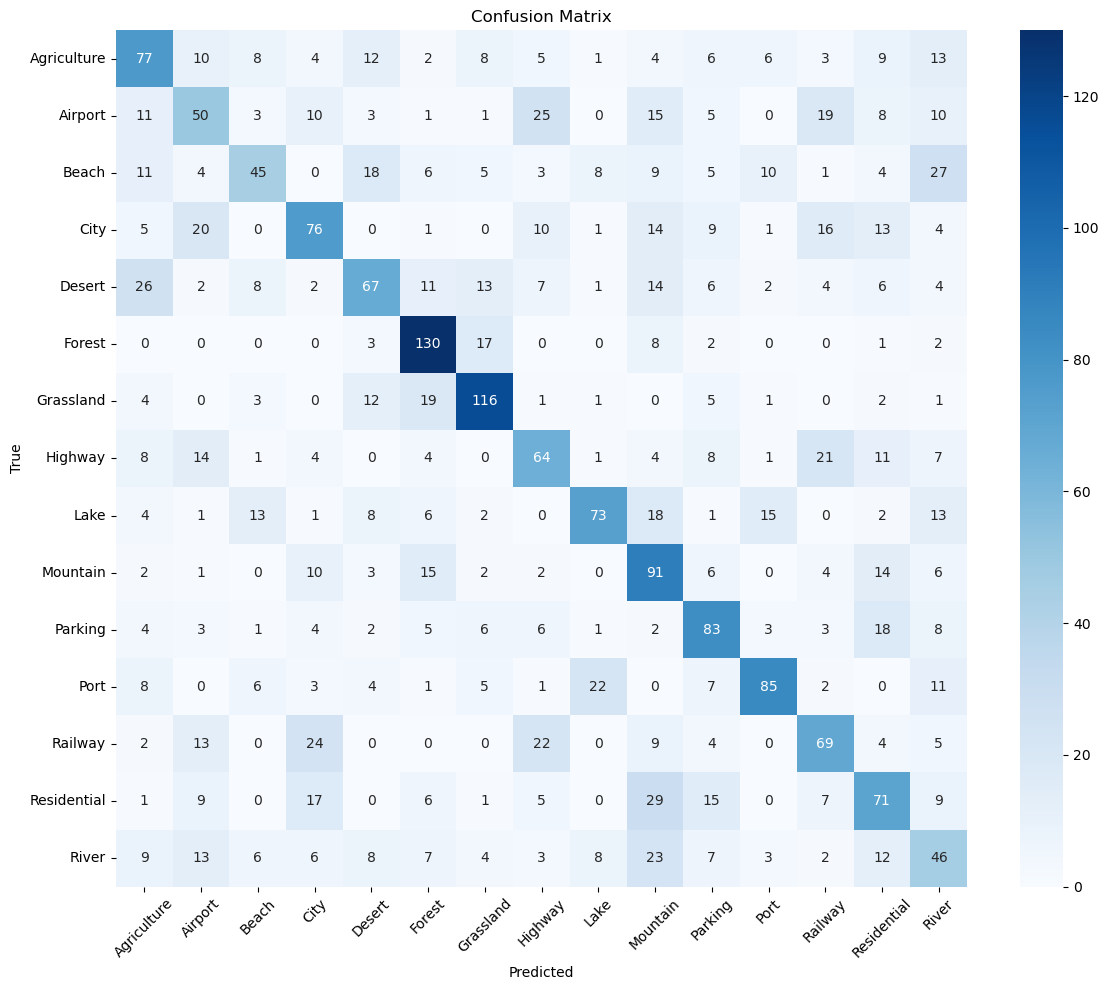

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix_augmented.png")
plt.show()

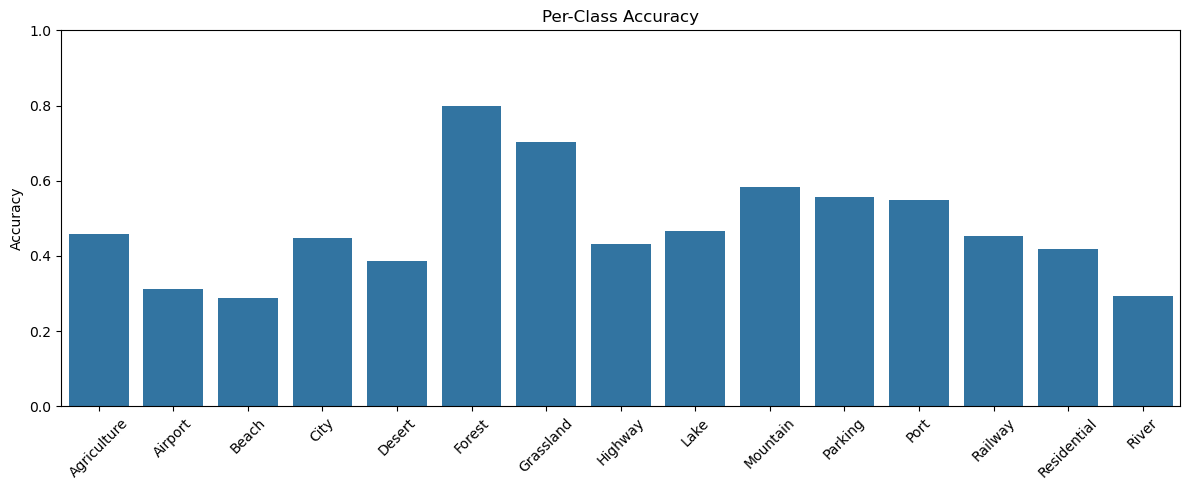

In [6]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 5))
sns.barplot(x=le.classes_, y=class_accuracy)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("per_class_accuracy_augmented.png")
plt.show()